In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

# TRAIN - TEST - VALIDATION (DATA SPLIT)
train_data = pd.read_csv("/content/gdrive/MyDrive/Research 2/dataset/train.csv")
test_data = pd.read_csv("/content/gdrive/MyDrive/Research 2/dataset/test.csv")
valid_data = pd.read_csv("/content/gdrive/MyDrive/Research 2/dataset/valid.csv")

print("Train Data", train_data.shape)
print("Test Data", test_data.shape)
print("Valid Data", valid_data.shape)

Train Data (287113, 4)
Test Data (11490, 4)
Valid Data (13368, 4)


In [ ]:
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from string import punctuation

In [ ]:
NUMERAL_THRESHOLD = 0.5
NER_THRESHOLD = 0.5
POS_THRESHOLD = 0.5

In [ ]:
nlp = spacy.load('en_core_web_sm')

# **Logics**

In [ ]:
def extraction_analysis(doc):
  # print("EXTRACTION ANALYSIS")
  _sentences = []
  i = 0
  n = len(list(doc.sents))
  # print("n =  ", n)

  for sent in doc.sents:
    if i in [0,1,2,n-1,n-2,n-3]:
      # print("i = ", i)
      _sentences.append(sent.text)
    i += 1
  # print("GENERIC SENTENCES")
  # print(_sentences)
  doc = nlp(" ".join(_sentences))
  numeral_check = numeral_analysis(doc)
  ner_check = ner_analysis(doc)
  pos_check = pos_analysis(doc)

  # print(numeral_check)
  # print(ner_check)
  # print(pos_check)

  possible_sentences = []
  _sentence_merge = {}
  for x in numeral_check:
    if x not in _sentence_merge.keys():
      _sentence_merge[x] = 1
    else:
      _sentence_merge[x] += 1
  for x in ner_check:
    if x not in _sentence_merge.keys():
      _sentence_merge[x] = 1
    else:
      _sentence_merge[x] += 1
  for x in pos_check:
    if x not in _sentence_merge.keys():
      _sentence_merge[x] = 1
    else:
      _sentence_merge[x] += 1

  # print(_sentence_merge)

  max_sentence = max(_sentence_merge.values())
  for k,v in _sentence_merge.items():
    if (v/max_sentence) > 0.5:
      possible_sentences.append(k)

  return possible_sentences

In [ ]:
def numeral_analysis(doc):
  # print("NUMERAL ANALYSIS")
  # print("THRESHOLD", NUMERAL_THRESHOLD)
  _sentences = []
  n = len(list(doc.sents))
  frequency = []
  sent_ind = []
  for sent in doc.sents:
    count = 0
    sent_doc = nlp(sent.text)
    for token in sent_doc:
      if token.like_num:
        count += 1
    frequency.append(count)
  # print(frequency)
  
  max_freq = max(frequency)
  # print(max_freq)
  if max_freq != 0:
    frequency = [(x/max_freq) for x in frequency]
    # print(frequency)
    for x in frequency:
      if x > NUMERAL_THRESHOLD:
        sent_ind.append(frequency.index(x))
        # _sentences.append(sent.text)
    i = 0
    for sent in doc.sents:
      if i in sent_ind:
        # print("i = ", i)
        _sentences.append(sent.text)
      i += 1
    # print(_sentences)
    # print(len(_sentences))
  return _sentences

In [ ]:
def ner_analysis(doc):
  # print("NER ANALYSIS")
  # print("THRESHOLD", NER_THRESHOLD)

  _sentences = []
  frequency = []
  sent_ind = []
  for sent in doc.sents:
    count = 0
    sent_doc = nlp(sent.text)
    for ent in sent_doc.ents:
      if ent.label_ in ['GPE', 'ORG', 'LAW']:
        count += 1
    frequency.append(count)
  # print(frequency)
  max_freq = max(frequency)
  # print(max_freq)
  if max_freq != 0:
    frequency = [(x/max_freq) for x in frequency]
    # print(frequency)
    for x in frequency:
      if x > NER_THRESHOLD:
        sent_ind.append(frequency.index(x))
        # _sentences.append(sent.text)
    
    i = 0
    for sent in doc.sents:
      if i in sent_ind:
        # print("i = ", i)
        _sentences.append(sent.text)
      i += 1
    # print(_sentences)
    # print(len(_sentences))
  return _sentences

In [ ]:
def pos_analysis(doc):
  # print("POS ANALYSIS")
  # print("THRESHOLD",POS_THRESHOLD)

  _sentences = []
  frequency = {}
  sent_ind = []
  stopwords = list(STOP_WORDS)
  i = 0
  for sent in doc.sents:
    count = 0
    sent_doc = nlp(sent.text)
    for token in sent_doc:
      if token.pos_ in ["PROPN", "VERB", "NOUN"] and token.text not in stopwords and token.text not in punctuation:
        count += 1
    frequency[i] = count
    i += 1
  # print(frequency)
  max_frequency = max(frequency.values())
  # print(max_frequency)

  if max_frequency != 0:
    for k,v in frequency.items():
      frequency[k] = (frequency[k]/max_frequency)
      if frequency[k] > POS_THRESHOLD:
        sent_ind.append(k)
    i = 0
    for sent in doc.sents:
      if i in sent_ind:
        # print("i = ", i)
        _sentences.append(sent.text)
      i += 1
    # print(_sentences)
    # print(len(_sentences))
  return _sentences

# **Summarization**

In [ ]:
import pandas as pd
data = pd.DataFrame(
    {'article': train_data['article'],
     'highlights': train_data['highlights'],
    })

data.head()

,article,highlights
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non..."
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical..."


In [ ]:
def similarity_evaluation(summary_analyser, highlights):
  
  s_doc = nlp(" ".join(summary_analyser))
  s_indices = {}

  i=0
  for s1 in s_doc.sents:
    j=0
    for s2 in s_doc.sents:
      if s1.similarity(s2) < 0.4 and (i<j):
        s_indices[i] = [-1, 1]
        s_indices[i][1] = min(s1.similarity(s2), s_indices[i][1])
        s_indices[i][0] = j
        # print(i, j, s1.similarity(s2))
      j+=1
    i+=1
  
  indices = list(s_indices.keys())
  for v in s_indices.values():
    if v[0] not in indices:
      indices.append(v[0])
  
  summary = " "
  k = 0
  c = 0
  for sent in s_doc.sents:
    if k in indices:
      summary += sent.text
      c += 1
    k += 1

  highlight_text = nlp(highlights)
  summary_text = nlp(summary)

  return summary_text.similarity(highlight_text)
  

In [ ]:
article_loop = 101
article_index = 0
correct = 0
summary_details = {}
start = time.time()

for article in data['article']:
  article_loop -= 1
  if article_loop == 0:
    break
  article_doc = nlp(article)
  highlight_doc = nlp(data['highlights'][article_index])
  summary_analyser = []
  
  ext_ = extraction_analysis(article_doc)
  for x in ext_:
    summary_analyser.append(x)
  
  num_ = numeral_analysis(article_doc)
  for x in num_:
    summary_analyser.append(x)

  ner_ = ner_analysis(article_doc)
  for x in ner_:
    summary_analyser.append(x)
  
  pos_ = pos_analysis(article_doc)
  for x in pos_:
    summary_analyser.append(x)
  
  print("Article Index", article_index)

  print("Ranked Sentences Length :", len(summary_analyser))

  ground_truth = similarity_evaluation(summary_analyser, data['highlights'][article_index])
  print("Accuracy", ground_truth)

  if ground_truth > 0.4:
    correct += 1

  article_details = {}
  article_details['article'] = article
  article_details['highlights'] = data['highlights'][article_index]
  article_details['article_len'] = len([s for s in article_doc.sents])
  article_details['highlights_len'] = len([s for s in highlight_doc.sents])
  article_details['summary'] = " ".join(summary_analyser)
  article_details['summary_len'] = len(summary_analyser)
  article_details['similarity'] = ground_truth

  summary_details[article_index] = article_details

  article_index += 1

  print("--------------------")

end = time.time()

print("+++++++++++++++++++++++++++ TIME / ANALYSIS +++++++++++++++++++++++++++")
print("Time Taken : ", (end-start)/60, "minutes")
print("Total Correct", correct)
print("Accuracy", (correct/(article_index-1)))


Article Index 0
Ranked Sentences Length : 10
Accuracy 0.6842196147505505
--------------------
Article Index 1
Ranked Sentences Length : 16
Accuracy 0.7182788890206826
--------------------
Article Index 2
Ranked Sentences Length : 20
Accuracy 0.6206717298554256
--------------------
Article Index 3
Ranked Sentences Length : 14
Accuracy 0.7719143468946963
--------------------
Article Index 4
Ranked Sentences Length : 21
Accuracy 0.6674363029779607
--------------------
Article Index 5
Ranked Sentences Length : 8
Accuracy 0.21264071755698946
--------------------
Article Index 6
Ranked Sentences Length : 17
Accuracy 0.7611452211330452
--------------------
Article Index 7
Ranked Sentences Length : 12
Accuracy 0.6635723624626225
--------------------
Article Index 8
Ranked Sentences Length : 7
Accuracy 0.09499044957680143
--------------------
Article Index 9
Ranked Sentences Length : 13
Accuracy 0.6403947365583573
--------------------
Article Index 10
Ranked Sentences Length : 17
Accuracy 0.723

In [ ]:
import json

json = json.dumps(summary_details)
f = open("train_100.json","w")
f.write(json)
f.close()

# **Evaluating the 11490 dataset**

In [ ]:
article_loop = 11490
article_index = 0
correct = 0
summary_details = {}
start = time.time()

for article in test_data['article']:

  article_loop -= 1
  if article_loop == 0:
    break
  article_doc = nlp(article)
  article_doc = nlp(test_data['highlights'][article_index])
  summary_analyser = []
  
  ext_ = extraction_analysis(article_doc)
  for x in ext_:
    summary_analyser.append(x)
  
  num_ = numeral_analysis(article_doc)
  for x in num_:
    summary_analyser.append(x)

  ner_ = ner_analysis(article_doc)
  for x in ner_:
    summary_analyser.append(x)
  
  pos_ = pos_analysis(article_doc)
  for x in pos_:
    summary_analyser.append(x)
  
  print("Article Index", article_index)

  print("Ranked Sentences Length :", len(summary_analyser))

  ground_truth = similarity_evaluation(summary_analyser, test_data['highlights'][article_index])
  print("Accuracy", ground_truth)

  if ground_truth > 0.4:
    correct += 1

  article_details = {}
  article_details['article'] = article
  article_details['highlights'] = test_data['highlights'][article_index]
  article_details['article_len'] = len([s for s in article_doc.sents])
  article_details['highlights_len'] = len([s for s in highlight_doc.sents])
  article_details['summary'] = " ".join(summary_analyser)
  article_details['summary_len'] = len(summary_analyser)
  article_details['similarity'] = ground_truth

  summary_details[article_index] = article_details

  article_index += 1

  print("--------------------")

end = time.time()

print("+++++++++++++++++++++++++++ TIME / ANALYSIS +++++++++++++++++++++++++++")
print("Time Taken : ", (end-start)/60, "minutes")
print("Total Correct", correct)
print("Accuracy", (correct/(article_index-1)))

Streaming output truncated to the last 5000 lines.
Article Index 10240
Ranked Sentences Length : 5
Accuracy 0.9500436017727449
--------------------
Article Index 10241
Ranked Sentences Length : 9
Accuracy 0.9561968756826184
--------------------
Article Index 10242
Ranked Sentences Length : 6
Accuracy 0.9337996490183551
--------------------
Article Index 10243
Ranked Sentences Length : 11
Accuracy 0.963146234558868
--------------------
Article Index 10244
Ranked Sentences Length : 6
Accuracy 0.9140726938079179
--------------------
Article Index 10245
Ranked Sentences Length : 3
Accuracy 0.20429814973139998
--------------------
Article Index 10246
Ranked Sentences Length : 7
Accuracy 0.04809323390991469
--------------------
Article Index 10247
Ranked Sentences Length : 8
Accuracy 0.9355858535835032
--------------------
Article Index 10248
Ranked Sentences Length : 8
Accuracy 0.03137758530339994
--------------------
Article Index 10249
Ranked Sentences Length : 5
Accuracy -0.0039676642498

In [ ]:
import json

json = json.dumps(summary_details)
f = open("train_all.json","w")
f.write(json)
f.close()

# **Evaluation using ROUGE score**

In [4]:
# !pip install rouge-score

**How to use rouge score**

In [5]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')

print(scores['rouge1'])
precision, recall, fmeasure = scores['rouge1']
print(precision)
print(recall)
print(fmeasure)

Score(precision=0.75, recall=0.6666666666666666, fmeasure=0.7058823529411765)
0.75
0.6666666666666666
0.7058823529411765


**ROUGE EVALUATION FOR TRAIN_100 JSON DATA**

In [19]:
import json
from rouge_score import rouge_scorer

json_data = {}

print("=========================================")
print("===============TRAIN_DATA_100============")
print("=========================================")
with open("train_100.json") as data_file:
  json_data = json.load(data_file)

# print(json_data)

overall_precision_1 = 0
overall_recall_1 = 0
overall_fmeasure_1 = 0

overall_precision_2 = 0
overall_recall_2 = 0
overall_fmeasure_2 = 0

overall_precision_l = 0
overall_recall_l = 0
overall_fmeasure_l = 0

for article_index, details in json_data.items():
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
  scores = scorer.score(details['summary'], details['highlights'])
  
  precision1,recall1,fmeasure1 = scores['rouge1']
  overall_precision_1 += precision1
  overall_recall_1 += recall1
  overall_fmeasure_1 += fmeasure1
  
  precision2,recall2,fmeasure2 = scores['rouge2']
  overall_precision_2 += precision2
  overall_recall_2 += recall2
  overall_fmeasure_2 += fmeasure2
  
  precisionl,recalll,fmeasurel = scores['rougeL']
  overall_precision_l += precisionl
  overall_recall_l += recalll
  overall_fmeasure_l += fmeasurel

print("ROUGE-1 METRIC")
print("Overall Precision", overall_precision_1/len(json_data.keys()))
print("Overall Recall", overall_recall_1/len(json_data.keys()))
print("Overall Fmeasure", overall_fmeasure_1/len(json_data.keys()))

print("ROUGE-2 METRIC")
print("Overall Precision", overall_precision_2/len(json_data.keys()))
print("Overall Recall", overall_recall_2/len(json_data.keys()))
print("Overall Fmeasure", overall_fmeasure_2/len(json_data.keys()))

print("ROUGE-L METRIC")
print("Overall Precision", overall_precision_l/len(json_data.keys()))
print("Overall Recall", overall_recall_l/len(json_data.keys()))
print("Overall Fmeasure", overall_fmeasure_l/len(json_data.keys()))

metrics = {}
metrics['rouge1'] = [overall_precision_1/len(json_data.keys()), overall_recall_1/len(json_data.keys()), overall_fmeasure_1/len(json_data.keys())]
metrics['rouge2'] = [overall_precision_2/len(json_data.keys()), overall_recall_2/len(json_data.keys()), overall_fmeasure_2/len(json_data.keys())]
metrics['rougeL'] = [overall_precision_l/len(json_data.keys()), overall_recall_l/len(json_data.keys()), overall_fmeasure_l/len(json_data.keys())]
json = json.dumps(metrics)
f = open("spacy_rouge_100.json","w")
f.write(json)
f.close()

===============TRAIN_DATA_100============
ROUGE-1 METRIC
Overall Precision 0.74977364076358
Overall Recall 0.07555792946237173
Overall Fmeasure 0.13554199398403394
ROUGE-2 METRIC
Overall Precision 0.3099176068102611
Overall Recall 0.03050177216830014
Overall Fmeasure 0.054872849173785
ROUGE-L METRIC
Overall Precision 0.5455573167331346
Overall Recall 0.054249661987664254
Overall Fmeasure 0.09751078842265021


**ROUGE EVALUATION FOR TRAIN_ALL JSON DATA**

In [20]:
import json
from rouge_score import rouge_scorer

json_data = {}

print("=========================================")
print("===============TRAIN_DATA_ALL============")
print("=========================================")
with open("train_all.json") as data_file:
  json_data = json.load(data_file)

# print(json_data)

overall_precision_1 = 0
overall_recall_1 = 0
overall_fmeasure_1 = 0

overall_precision_2 = 0
overall_recall_2 = 0
overall_fmeasure_2 = 0

overall_precision_l = 0
overall_recall_l = 0
overall_fmeasure_l = 0

for article_index, details in json_data.items():
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
  scores = scorer.score(details['summary'], details['highlights'])

  precision1,recall1,fmeasure1 = scores['rouge1']
  overall_precision_1 += precision1
  overall_recall_1 += recall1
  overall_fmeasure_1 += fmeasure1

  precision2,recall2,fmeasure2 = scores['rouge2']
  overall_precision_2 += precision2
  overall_recall_2 += recall2
  overall_fmeasure_2 += fmeasure2
  
  precisionl,recalll,fmeasurel = scores['rougeL']
  overall_precision_l += precisionl
  overall_recall_l += recalll
  overall_fmeasure_l += fmeasurel

print("ROUGE-1 METRIC")
print("Overall Precision", overall_precision_1/len(json_data.keys()))
print("Overall Recall", overall_recall_1/len(json_data.keys()))
print("Overall Fmeasure", overall_fmeasure_1/len(json_data.keys()))

print("ROUGE-2 METRIC")
print("Overall Precision", overall_precision_2/len(json_data.keys()))
print("Overall Recall", overall_recall_2/len(json_data.keys()))
print("Overall Fmeasure", overall_fmeasure_2/len(json_data.keys()))

print("ROUGE-L METRIC")
print("Overall Precision", overall_precision_l/len(json_data.keys()))
print("Overall Recall", overall_recall_l/len(json_data.keys()))
print("Overall Fmeasure", overall_fmeasure_l/len(json_data.keys()))

metrics = {}
metrics['rouge1'] = [overall_precision_1/len(json_data.keys()), overall_recall_1/len(json_data.keys()), overall_fmeasure_1/len(json_data.keys())]
metrics['rouge2'] = [overall_precision_2/len(json_data.keys()), overall_recall_2/len(json_data.keys()), overall_fmeasure_2/len(json_data.keys())]
metrics['rougeL'] = [overall_precision_l/len(json_data.keys()), overall_recall_l/len(json_data.keys()), overall_fmeasure_l/len(json_data.keys())]
json = json.dumps(metrics)
f = open("spacy_rouge_all.json","w")
f.write(json)
f.close()

===============TRAIN_DATA_ALL============
ROUGE-1 METRIC
Overall Precision 0.935000511956558
Overall Recall 0.5278148587213581
Overall Fmeasure 0.6672358777398915
ROUGE-2 METRIC
Overall Precision 0.9173738968912865
Overall Recall 0.5113335870697466
Overall Fmeasure 0.6492531306584468
ROUGE-L METRIC
Overall Precision 0.9191004723492465
Overall Recall 0.5169100070107314
Overall Fmeasure 0.6544383637659487


In [21]:
# !pip install matplotlib

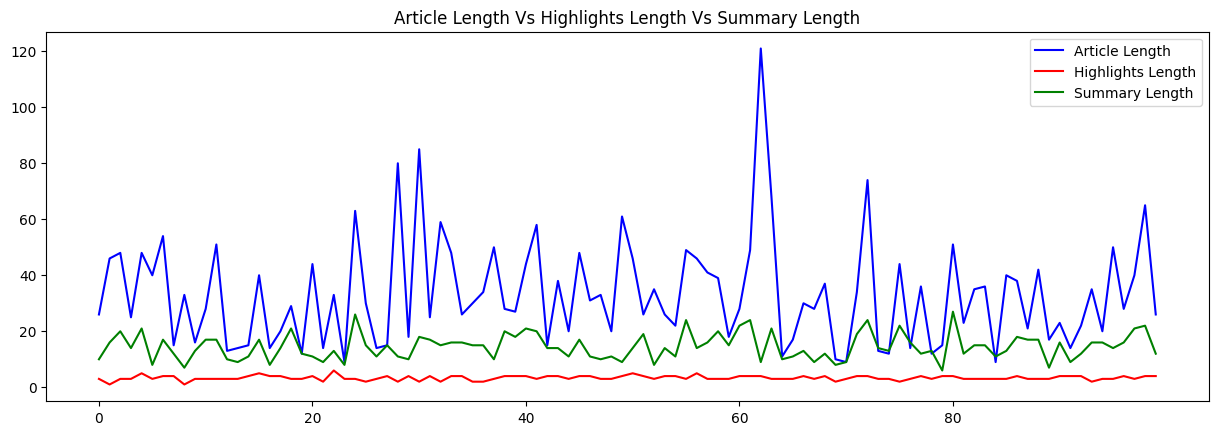

In [17]:
import matplotlib.pyplot as plt 
import json
import numpy as np

json_data = {}

with open("train_100.json") as data_file:
  json_data = json.load(data_file)

epochs = []
article_lens = []
highlight_lens = []
summary_lens = []

for data_key, data in json_data.items():
  epochs.append(data_key)
  article_lens.append(data['article_len'])
  highlight_lens.append(data['highlights_len'])
  summary_lens.append(data['summary_len'])

plt.figure().set_figwidth(15)
plt.plot(epochs, article_lens, label='Article Length', color="blue")
plt.plot(epochs, highlight_lens, label='Highlights Length', color="red")
plt.plot(epochs, summary_lens, label='Summary Length', color="green")
plt.xticks(np.arange(0, 99, 20))
plt.legend()
plt.title('Article Length Vs Highlights Length Vs Summary Length')
plt.show()

{'rouge1': [0.74977364076358, 0.07555792946237173, 0.13554199398403394], 'rouge2': [0.3099176068102611, 0.03050177216830014, 0.054872849173785], 'rougeL': [0.5455573167331346, 0.054249661987664254, 0.09751078842265021]}


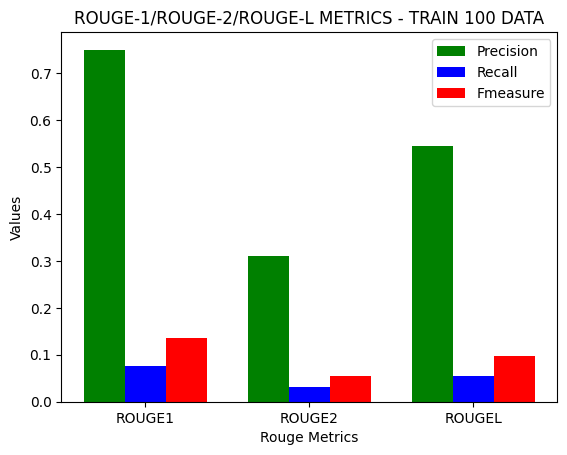

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import json
  
# creating the dataset
json_data = {}

with open("spacy_rouge_100.json") as data_file:
  json_data = json.load(data_file)

precision = []
recall = []
fmeasure = []
for metric, values in json_data.items():
  precision.append(values[0])
  recall.append(values[1])
  fmeasure.append(values[2])

print(json_data)
rouge_metrics = list(json_data.keys())
  
br1 = np.arange(len(precision))
br2 = [x + 0.25 for x in br1]
br3 = [x + 0.25 for x in br2]

plt.bar(br1, precision, color ='green', label="Precision", width=0.25)
plt.bar(br2, recall, color ='blue', label="Recall", width=0.25)
plt.bar(br3, fmeasure, color ='red', label="Fmeasure", width=0.25)

plt.xlabel("Rouge Metrics")
plt.ylabel("Values")
plt.xticks([r + 0.25 for r in range(len(precision))],
        ["ROUGE1", "ROUGE2", "ROUGEL"])
plt.title("ROUGE-1/ROUGE-2/ROUGE-L METRICS - TRAIN 100 DATA")
plt.legend()
plt.show()

{'rouge1': [0.935000511956558, 0.5278148587213581, 0.6672358777398915], 'rouge2': [0.9173738968912865, 0.5113335870697466, 0.6492531306584468], 'rougeL': [0.9191004723492465, 0.5169100070107314, 0.6544383637659487]}


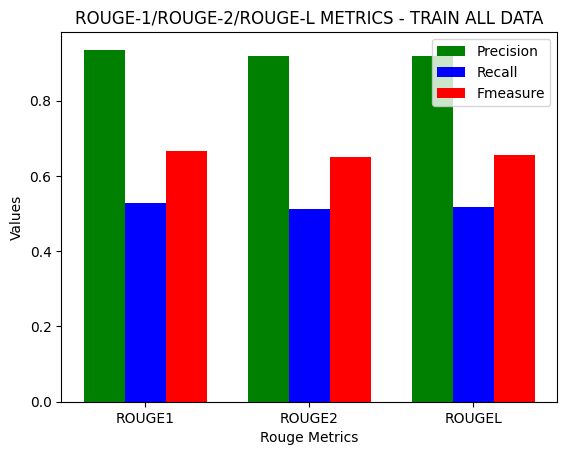

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import json
  
# creating the dataset
json_data = {}

with open("spacy_rouge_all.json") as data_file:
  json_data = json.load(data_file)

precision = []
recall = []
fmeasure = []
for metric, values in json_data.items():
  precision.append(values[0])
  recall.append(values[1])
  fmeasure.append(values[2])

print(json_data)
rouge_metrics = list(json_data.keys())
  
br1 = np.arange(len(precision))
br2 = [x + 0.25 for x in br1]
br3 = [x + 0.25 for x in br2]

plt.bar(br1, precision, color ='green', label="Precision", width=0.25)
plt.bar(br2, recall, color ='blue', label="Recall", width=0.25)
plt.bar(br3, fmeasure, color ='red', label="Fmeasure", width=0.25)

plt.xlabel("Rouge Metrics")
plt.ylabel("Values")
plt.xticks([r + 0.25 for r in range(len(precision))],
        ["ROUGE1", "ROUGE2", "ROUGEL"])
plt.title("ROUGE-1/ROUGE-2/ROUGE-L METRICS - TRAIN ALL DATA")
plt.legend()
plt.show()